Importing Packages

In [1]:
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf as acf #Autocorrelation Functions
from statsmodels.tsa.stattools import adfuller #Augmented Dickey-Fuller test for stationary testing
from statsmodels.tsa.seasonal import seasonal_decompose #Seasonal Decomposition Function
from sklearn.metrics import mean_squared_error #RMSE Calculation
import statsmodels.api as sm

Importing CSV FX Data

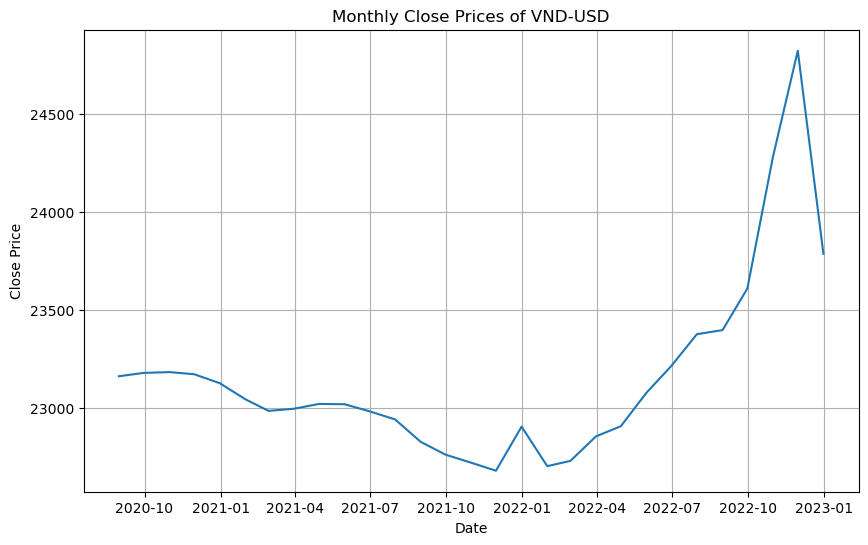

In [2]:
# Filepath to the CSV file
filepath = r"C:\Users\ariff_n\Downloads\VND=X.csv"

# Read the CSV file
fxdata = pd.read_csv(filepath)

# Remove rows containing NaN values
fxdata = fxdata.dropna(axis=0)

# Retaining only Date and Close columns
fxdata = fxdata[['Date', 'Close']]

# Convert 'Date' column to datetime format
fxdata['Date'] = pd.to_datetime(fxdata['Date'])

# Set 'Date' column as the index
fxdata.set_index('Date', inplace=True)

# Resample the data to monthly frequency
fxdata_monthly = fxdata['Close'].resample('M').mean()

# Filter data from August 2020 to December 2022
fxdata_monthly = fxdata_monthly['2020-08-01':'2022-12-31']

# Plotting the monthly data
plt.figure(figsize=(10, 6))
plt.plot(fxdata_monthly.index, fxdata_monthly.values)
plt.title('Monthly Close Prices of VND-USD')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

Fetching Data

C:\Users\ariff_n\AppData\Local\Temp\ipykernel_50440\1603512617.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ivdata = pd.read_csv(filepath, parse_dates=['Date'])


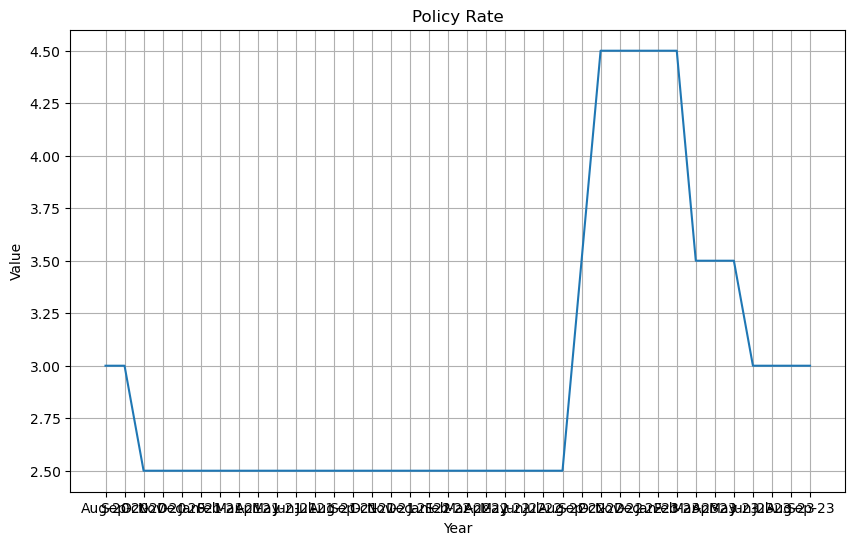

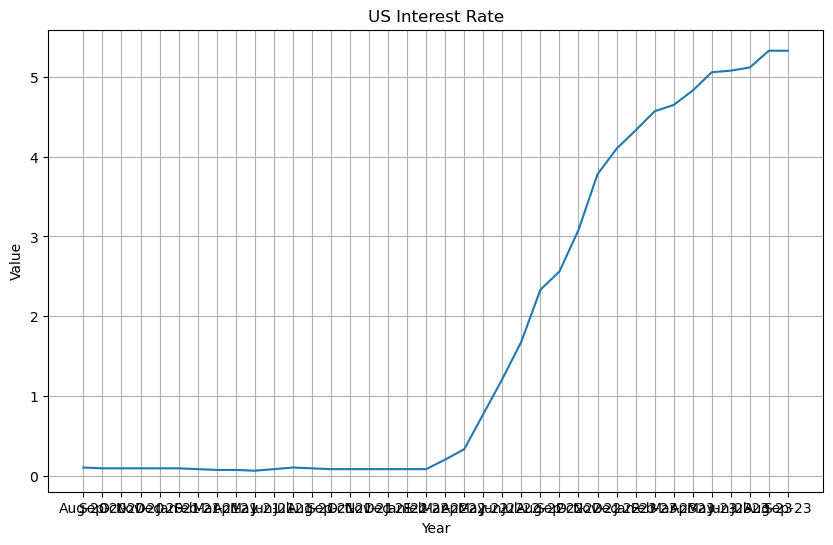

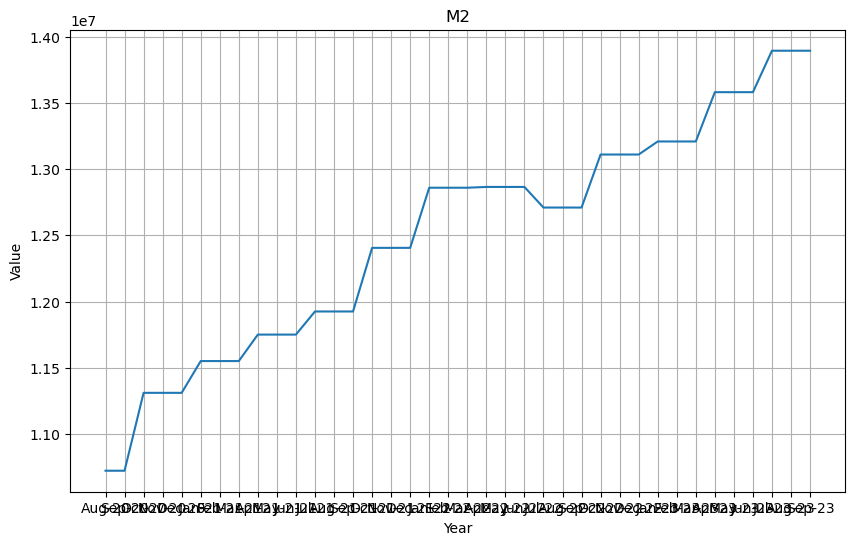

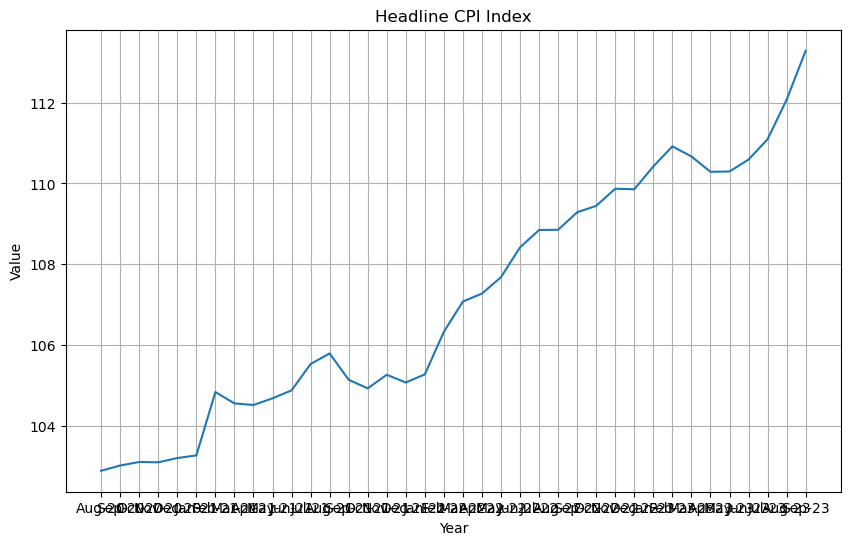

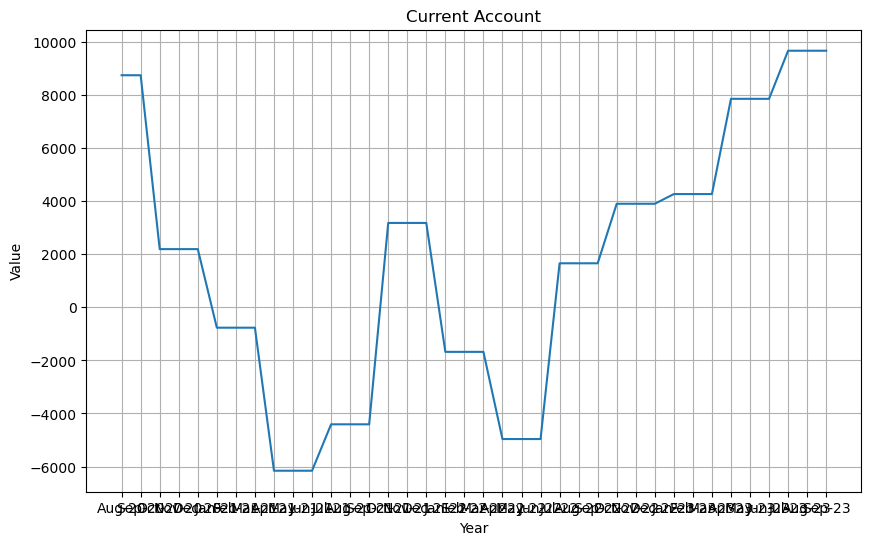

        Policy Rate  US Interest Rate           M2  Headline CPI Index  \
Date                                                                     
Aug-20          3.0              0.10  10722812.21          102.892800   
Sep-20          3.0              0.09  10722812.21          103.020901   
Oct-20          2.5              0.09  11310702.39          103.109397   
Nov-20          2.5              0.09  11310702.39          103.100735   
Dec-20          2.5              0.09  11310702.39          103.206723   
Jan-21          2.5              0.09  11550560.72          103.271124   
Feb-21          2.5              0.08  11550560.72          104.838883   
Mar-21          2.5              0.07  11550560.72          104.558229   
Apr-21          2.5              0.07  11750369.58          104.518183   
May-21          2.5              0.06  11750369.58          104.683740   
Jun-21          2.5              0.08  11750369.58          104.879917   
Jul-21          2.5              0.10 

In [14]:
# Filepath to the CSV file
filepath = r"C:\Users\ariff_n\Documents\Vietnam\CompiledData.csv"

# Read the CSV file, specifying the date format
ivdata = pd.read_csv(filepath, parse_dates=['Date'])

# Set the 'Date' column as the index
ivdata.set_index('Date', inplace=True)

# Retaining only wanted data
ivdata = ivdata[['Policy Rate', 'US Interest Rate', 'M2', 'Headline CPI Index', 'Current Account']]

# Drop rows with NaN values
ivdata.dropna(inplace=True)

# Plot each numeric column
for column in ivdata.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    plt.plot(ivdata.index, ivdata[column])
    plt.title(column)
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

print(ivdata)

Combining IV and DV into one Dataframe

In [4]:
ivdata.index = pd.to_datetime(ivdata.index, format='%b-%y')
fulldataset = pd.concat([fxdata_monthly, ivdata], axis=0)
fulldataset = fulldataset.sort_index()
fulldataset.columns = ['FX Data'] + list(fulldataset.columns[1:])
fulldataset['FX Data'] = fulldataset['FX Data'].ffill()
fulldataset = fulldataset.dropna()

In [5]:
print(fulldataset)

                 FX Data  Policy Rate  US Interest Rate           M2  \
Date                                                                   
2020-09-01  23160.611700          3.0              0.09  10722812.21   
2020-10-01  23177.590909          2.5              0.09  11310702.39   
2020-11-01  23181.727273          2.5              0.09  11310702.39   
2020-12-01  23170.952381          2.5              0.09  11310702.39   
2021-01-01  23125.173913          2.5              0.09  11550560.72   
2021-02-01  23043.113095          2.5              0.08  11550560.72   
2021-03-01  22983.938770          2.5              0.07  11550560.72   
2021-04-01  22995.051291          2.5              0.07  11750369.58   
2021-05-01  23019.410156          2.5              0.06  11750369.58   
2021-06-01  23017.964750          2.5              0.08  11750369.58   
2021-07-01  22981.911577          2.5              0.10  11924872.67   
2021-08-01  22940.540216          2.5              0.09  1192487

Scatterplot Matrix

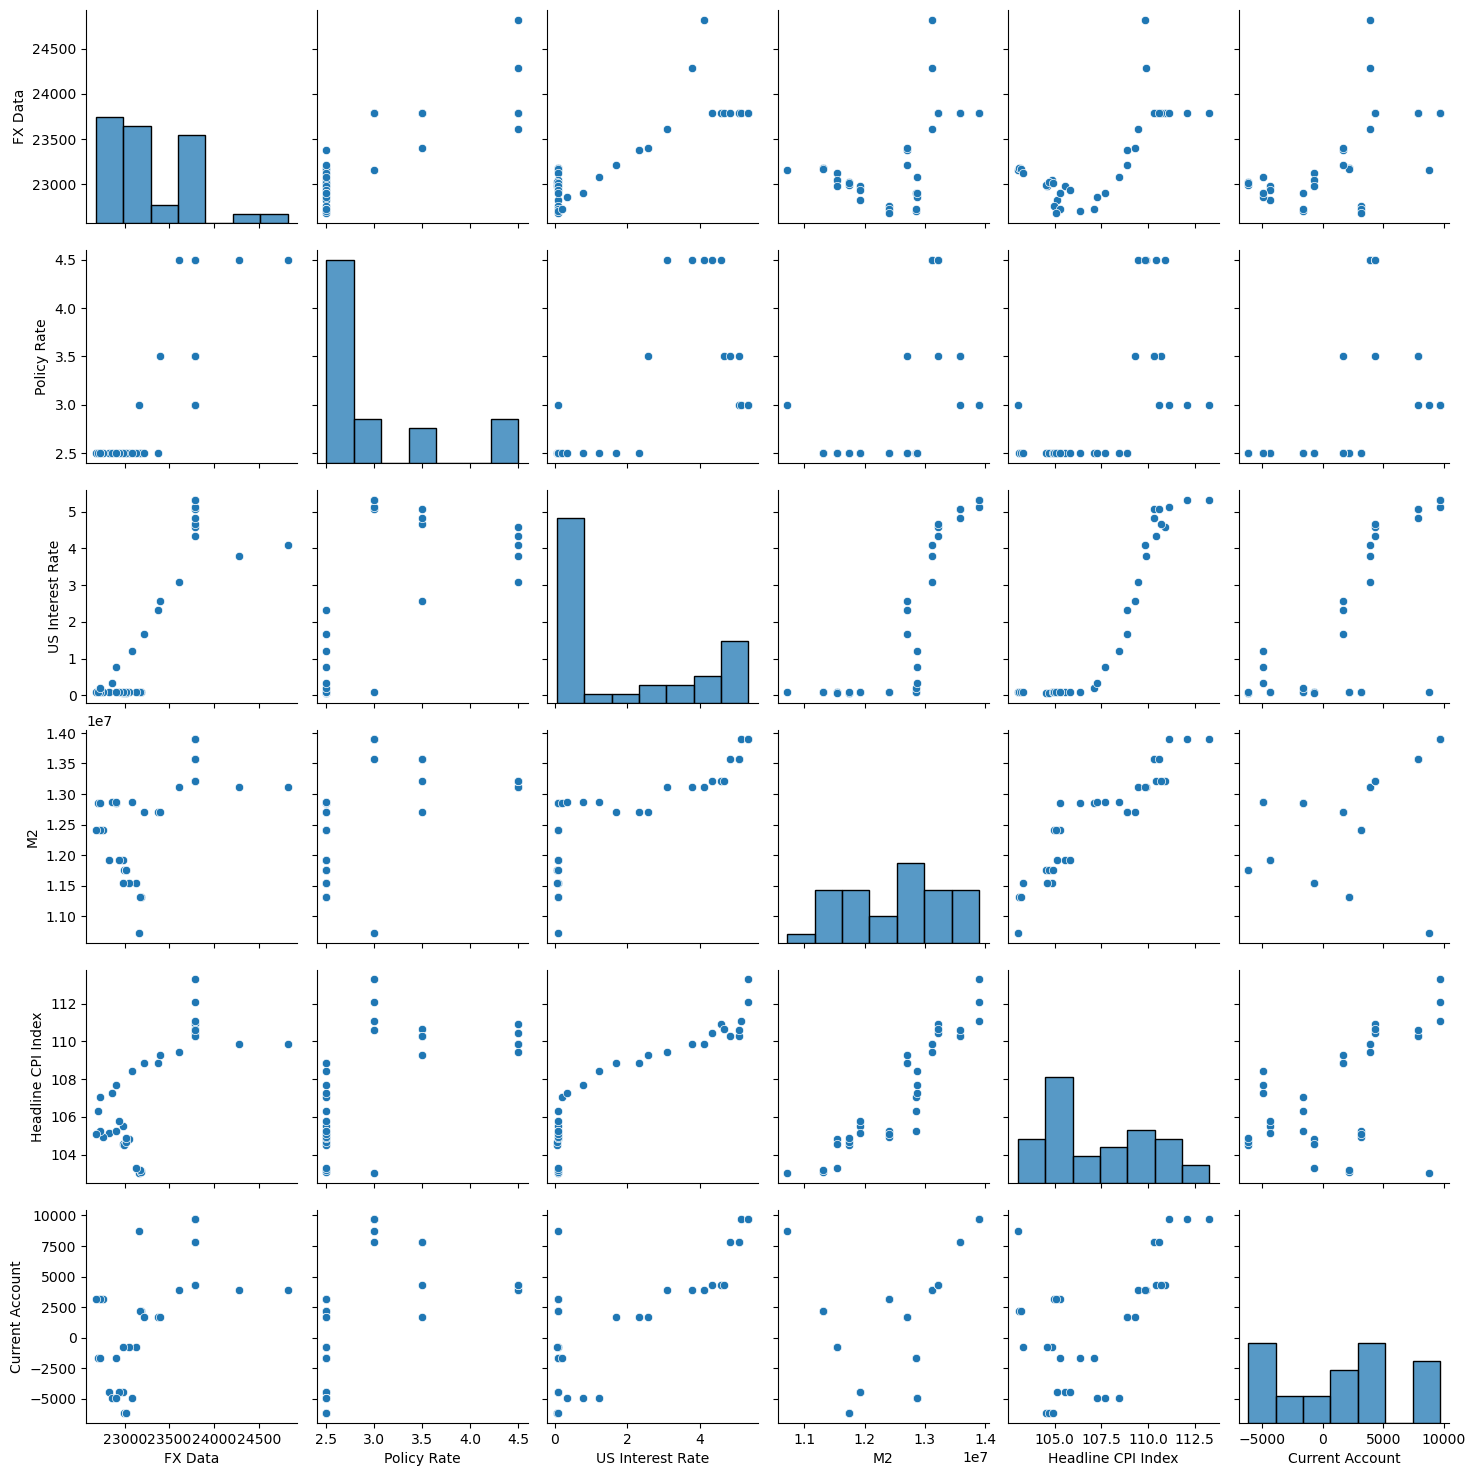

In [6]:
sns.pairplot(fulldataset)
plt.show()

ACF Stationarity Check

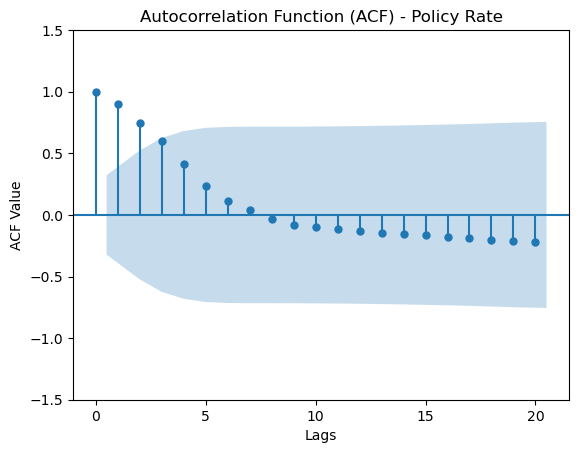

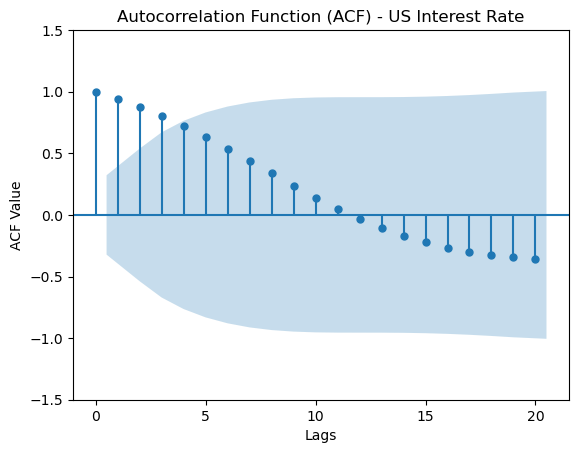

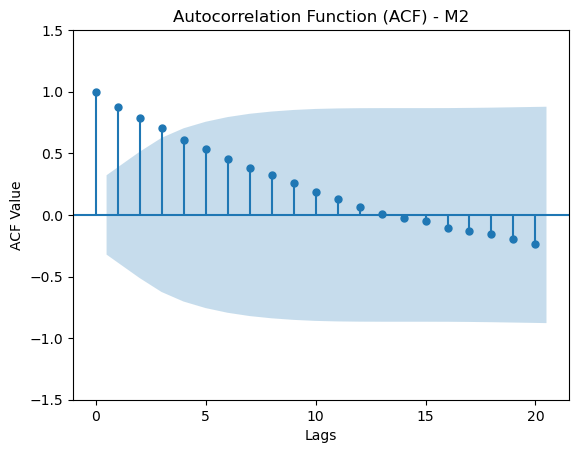

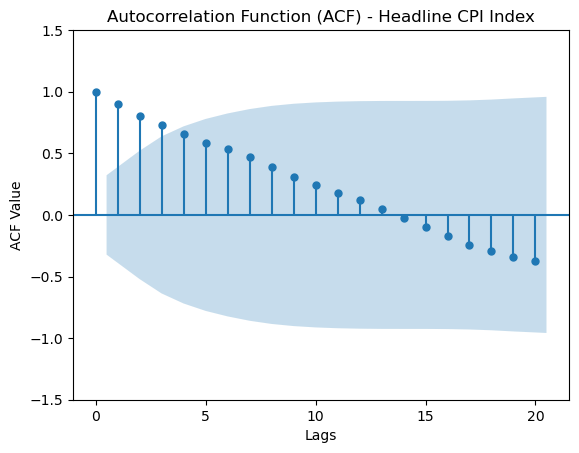

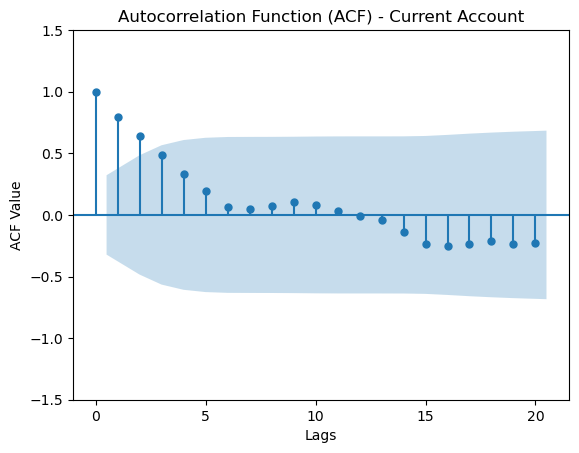

In [7]:
def acf_plot(fulldataset, variable_names):
    for variable_name in variable_names:
        if variable_name != 'FX Data':  # Exclude 'FX Data'
            acf(fulldataset[variable_name], lags=20)
            plt.title("Autocorrelation Function (ACF) - " + variable_name)
            plt.xlabel("Lags")
            plt.ylabel("ACF Value")
            plt.ylim(-1.5, 1.5)
            plt.show()

# Getting all IV data
variable_names = fulldataset.columns.tolist()
variable_names.remove('FX Data')

# Plotting each variable except 'FX Data'
acf_plot(fulldataset, variable_names)

ADF Check

Performing ADF test for 'Policy Rate' before seasonal adjustment:
ADF Test Result - Policy Rate
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.1076552460415474
P-Value: 0.5418073479218545
Number of lags: 9
Number of observations: 27
Critical Values: {'1%': -4.339881664888482, '5%': -3.5877977071584612, '10%': -3.2293340725499164}

Performing ADF test for 'US Interest Rate' before seasonal adjustment:
ADF Test Result - US Interest Rate
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.3802377248769284
P-Value: 0.05408483151826766
Number of lags: 3
Number of observations: 33
Critical Values: {'1%': -4.262944107465843, '5%': -3.553092543339733, '10%': -3.2096284957008097}

Performing ADF test for 'M2' before seasonal adjustment:
ADF Test Result - M2
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.42770568392011
P-Value: 0.36499634065590036
Number of lags: 3
Number of observations: 33
Critical Value

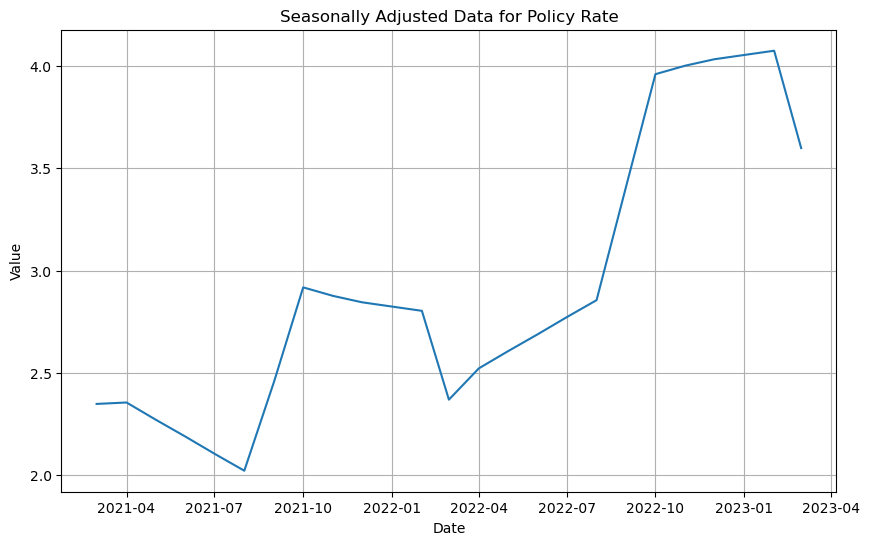

ADF Test Result - US Interest Rate
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.3802377248769284
P-Value: 0.05408483151826766
Number of lags: 3
Number of observations: 33
Critical Values: {'1%': -4.262944107465843, '5%': -3.553092543339733, '10%': -3.2096284957008097}
ADF Test Result - M2
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.42770568392011
P-Value: 0.36499634065590036
Number of lags: 3
Number of observations: 33
Critical Values: {'1%': -4.262944107465843, '5%': -3.553092543339733, '10%': -3.2096284957008097}
Performing seasonal adjustment for column 'M2'
Performing ADF test for 'M2' after seasonal adjustment:
ADF Test Result - M2
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.42770568392011
P-Value: 0.36499634065590036
Number of lags: 3
Number of observations: 33
Critical Values: {'1%': -4.262944107465843, '5%': -3.553092543339733, '10%': -3.2096284957008097}



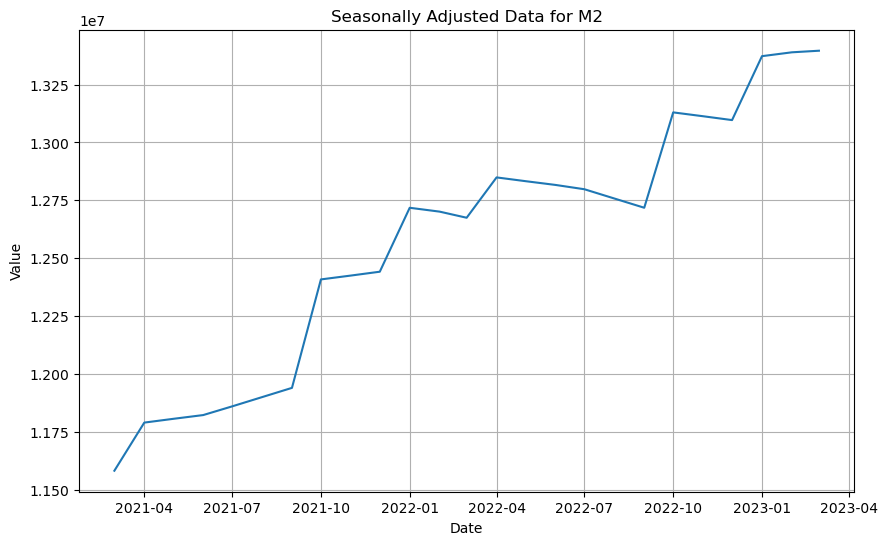

ADF Test Result - Headline CPI Index
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.2392710682801833
P-Value: 0.4677870917804397
Number of lags: 3
Number of observations: 33
Critical Values: {'1%': -4.262944107465843, '5%': -3.553092543339733, '10%': -3.2096284957008097}
Performing seasonal adjustment for column 'Headline CPI Index'
Performing ADF test for 'Headline CPI Index' after seasonal adjustment:
ADF Test Result - Headline CPI Index
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.2392710682801833
P-Value: 0.4677870917804397
Number of lags: 3
Number of observations: 33
Critical Values: {'1%': -4.262944107465843, '5%': -3.553092543339733, '10%': -3.2096284957008097}



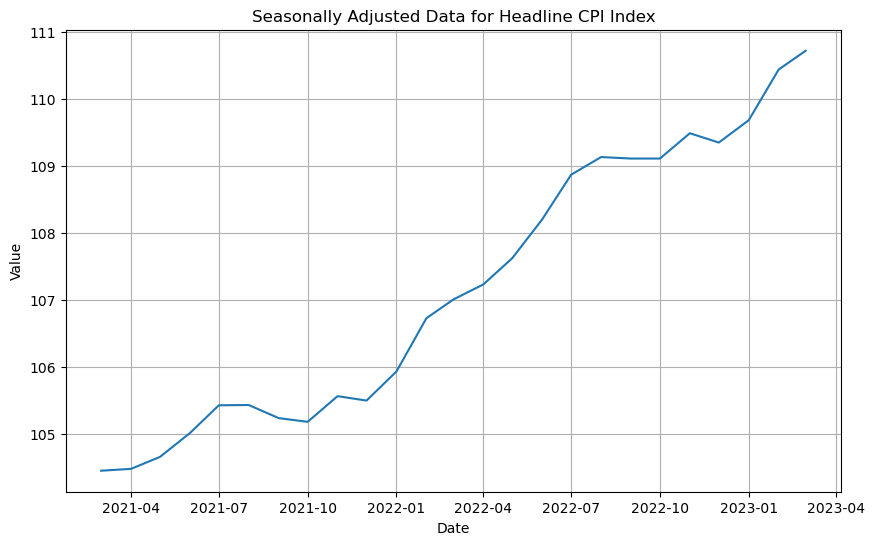

ADF Test Result - Current Account
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.748296343677816
P-Value: 0.019367390025987023
Number of lags: 6
Number of observations: 30
Critical Values: {'1%': -4.2970953703703705, '5%': -3.5685571851851847, '10%': -3.2184266666666668}
Performing moving average for non-stationary adjusted data: Policy Rate
Performing ADF test for 'Policy Rate' after moving average:
ADF Test Result - Policy Rate
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.1076552460415474
P-Value: 0.5418073479218545
Number of lags: 9
Number of observations: 27
Critical Values: {'1%': -4.339881664888482, '5%': -3.5877977071584612, '10%': -3.2293340725499164}

Moving average did not make 'Policy Rate' stationary.
Performing moving average for non-stationary adjusted data: M2
Performing ADF test for 'M2' after moving average:
ADF Test Result - M2
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: 

In [13]:
# Function for ADF test
def adf_check(imfdata, variable_name):
    adftest = sm.tsa.stattools.adfuller(imfdata[variable_name], autolag='AIC', regression='ct')
    print("ADF Test Result - "+variable_name)
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    return adftest[1]  # Return p-value for further processing

# Initialize lists to store information about adjusted data
adjusted_data_stationary = []
adjusted_data_non_stationary = []
unadjusted_data_stationary = []
unadjusted_data_non_stationary = []

# Perform ADF test for each column before seasonal adjustment
adf_results_before = {}
for column in fulldataset.columns:
    if column != 'FX Data':  # Exclude the 'FX Data' column if present
        print(f"Performing ADF test for '{column}' before seasonal adjustment:")
        p_value_before = adf_check(fulldataset, column)
        adf_results_before[column] = p_value_before
        print()

# Perform seasonal adjustment for data not stationary
adf_results_after = {}
for column in fulldataset.columns:
    if column != 'FX Data':  # Exclude the 'FX Data' column if present
        p_value = adf_check(fulldataset, column)
        if p_value > 0.15:  # Adjusted cutoff to 0.15
            print(f"Performing seasonal adjustment for column '{column}'")
            
            # Perform seasonal decomposition
            decomposition = sm.tsa.seasonal_decompose(fulldataset[column], model='additive')
            
            # Extract the residual component (seasonally adjusted data)
            seasonally_adjusted = fulldataset[column] - decomposition.resid
            
            # Perform ADF test after seasonal adjustment
            print(f"Performing ADF test for '{column}' after seasonal adjustment:")
            p_value_after = adf_check(fulldataset, column)
            print()
            
            # Add the column to the list of adjusted data
            if p_value_after <= 0.15:  # Adjusted cutoff to 0.15
                adjusted_data_stationary.append(column)
            else:
                adjusted_data_non_stationary.append(column)
            
            # Plot the seasonally adjusted data
            plt.figure(figsize=(10, 6))
            plt.plot(seasonally_adjusted.index, seasonally_adjusted.values)
            plt.title(f'Seasonally Adjusted Data for {column}')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.grid(True)
            plt.show()
        else:
            if adf_results_before[column] <= 0.15:  # Adjusted cutoff to 0.15
                unadjusted_data_stationary.append(column)
            else:
                unadjusted_data_non_stationary.append(column)

# Perform moving average for non-stationary adjusted data
for column in adjusted_data_non_stationary:
    print(f"Performing moving average for non-stationary adjusted data: {column}")
    
    # Calculate moving average based on original data
    window_size = 3  # Adjust window size as needed
    moving_average = fulldataset[column].rolling(window=window_size).mean()
    
    # Perform ADF test after moving average
    print(f"Performing ADF test for '{column}' after moving average:")
    p_value_after_ma = adf_check(fulldataset, column)
    print()
    
    # If the data becomes stationary after moving average, add it to the list of adjusted data
    if p_value_after_ma <= 0.15:  # Adjusted cutoff to 0.15
        adjusted_data_stationary.append(f"MA({window_size}) {column}")
    else:
        print(f"Moving average did not make '{column}' stationary.")

# Summary of adjusted data
print("\033[1mSummary of Seasonal Adjustment:\033[0m")
print("------------------------------------")
print("\033[1mAdjusted Data (Stationary):\033[0m")
for column in adjusted_data_stationary:
    print(column)
print("\n\033[1mAdjusted Data (Non-Stationary):\033[0m")
for column in adjusted_data_non_stationary:
    print(column)
print("\n\033[1mUnadjusted Data (Stationary):\033[0m")
for column in unadjusted_data_stationary:
    print(column)
print("\n\033[1mUnadjusted Data (Non-Stationary):\033[0m")
for column in unadjusted_data_non_stationary:
    print(column)


def adf_check(data, variable_name): 
    adftest = adfuller(data[variable_name], autolag='AIC', regression='ct')
    print("ADF Test Result - "+variable_name)
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    if adftest[1] <= 0.1:
        print("\033[1mThe series is stationary (P-Value <= 0.1)\033[0m")
        print("\n")
        return 0
    else:
        print("\033[1mThe series is not stationary (P-Value > 0.1)\033[0m")
        print("\n")
        return 1

# Initialize adf_results DataFrame with variable names
adf_results_before = pd.DataFrame({'Variable': ivdata.columns})
adf_results_after = pd.DataFrame({'Variable': ivdata.columns})

# Add columns for ADF test result and Stationarity Treatment Required for both before and after
adf_results_before['ADF Test Result'] = ''
adf_results_before['Stationarity Treatment Required'] = ''

adf_results_after['ADF Test Result'] = ''
adf_results_after['Stationarity Treatment Required'] = ''

# List to store processed variables
processed_variables = []

# Iterate over each variable
for variable_name in ivdata.columns:
    if variable_name != 'FX Data' and variable_name not in processed_variables:
        # Perform ADF test before transformation
        result_before = adf_check(ivdata, variable_name)
        
        # Update ADF test result and Stationarity Treatment Required for before transformation
        adf_results_before.loc[adf_results_before['Variable'] == variable_name, 'ADF Test Result'] = result_before
        adf_results_before.loc[adf_results_before['Variable'] == variable_name, 'Stationarity Treatment Required'] = result_before
        
        # Apply differencing if needed
        transformed = False
        if result_before == 1:
            ivdata['Diff ' + variable_name] = ivdata[variable_name].diff()
            transformed = True
            print(f"Differencing applied to {variable_name}")

        # Perform ADF test after transformation
        result_after = adf_check(ivdata, 'Diff ' + variable_name if transformed else variable_name)
        
        # Update ADF test result and Stationarity Treatment Required for after transformation
        adf_results_after.loc[adf_results_after['Variable'] == variable_name, 'ADF Test Result'] = result_after
        adf_results_after.loc[adf_results_after['Variable'] == variable_name, 'Stationarity Treatment Required'] = result_after
        
        # Update the variable name in the DataFrame after transformation
        if transformed:
            adf_results_after.loc[adf_results_after['Variable'] == variable_name, 'Variable'] = 'Diff ' + variable_name
        
        # Add the variable to the processed list
        processed_variables.append(variable_name)

print("\033[1m\nSummary of ADF Test Before Transformation:\033[0m")
print(adf_results_before)

print("\033[1m\nSummary of ADF Test After Transformation:\033[0m")
print(adf_results_after)

def adf_check(ivdata, variable_name): 
    adftest = adfuller(ivdata[variable_name], autolag='AIC', regression='ct')
    print("ADF Test Result - "+variable_name)
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    if adftest[1] <= 0.1:
        print("\033[1mThe series is stationary (P-Value <= 0.1)\033[0m")
        print("\n")
        return 0
    else:
        print("\033[1mThe series is not stationary (P-Value > 0.1)\033[0m")
        print("\n")
        return 1
    
# DataFrame to store the results
adf_results = pd.DataFrame(columns=['Variable', 'Stationarity Treatment Required'])

# Iterate over each variable
for variable_name in ivdata.columns:
    if variable_name != 'FX Data':
        result = adf_check(ivdata, variable_name)
        # Add the results to the DataFrame
        adf_results.loc[len(adf_results)] = [variable_name, result]
        
print("\033[1m\nSummary of ADF Test:\033[0m")
print(adf_results)

Stationarity Treatment via Logarithmic Conversion

# Apply logarithmic transformation to variables requiring treatment
if not adf_results.empty:
    for variable_name in ivdata.columns:
        if adf_results['Variable'].str.contains(variable_name).any():
            if adf_results.loc[adf_results['Variable'] == variable_name, 'Stationarity Treatment Required'].values[0] == 1:
                # Check for negative values
                if (ivdata[variable_name] > 0).all():
                    # Adding a small constant to each value before taking logarithm to handle negative values
                    ivdata[variable_name] = np.log(ivdata[variable_name] + 1e-9)  # Adding a small constant (1e-9)
                    ivdata = ivdata.rename(columns={variable_name: 'Log ' + variable_name})
                    print(f"Logarithmic transformation applied to {variable_name}")
                else:
                    print(f"Skipping logarithmic transformation for {variable_name} due to negative values")
                    # Perform differencing directly
                    ivdata['Diff ' + variable_name] = ivdata[variable_name].diff().dropna()
                    print(f"Differences taken for {variable_name}")
else:
    print("No variables require treatment.")

print("\033[1m\nLogarithmic Transformation Applied to Variables Requiring Treatment:\033[0m")
print(ivdata)

# DataFrame to store the results after treatment
adf_results_after_treatment = pd.DataFrame(columns=['Variable', 'Stationarity Treatment Required'])

# List to store processed variables after treatment
processed_variables_after_treatment = []

# Iterate over each variable after logarithmic transformation
for variable_name in ivdata.columns:
    if variable_name.startswith('Log ') or variable_name.startswith('Diff '):
        variable_name_split = variable_name.split(' ')
        if len(variable_name_split) == 2:  # Check if split result contains two parts
            if variable_name_split[0] == 'Log' and adf_results['Variable'].str.contains(variable_name_split[1]).any():
                if variable_name.startswith('Diff '):
                    result = adf_check(ivdata, variable_name)
                else:
                    # Check if the differenced column exists
                    if 'Diff ' + variable_name_split[1] in ivdata.columns:
                        result = adf_check(ivdata, 'Diff ' + variable_name_split[1])
                    else:
                        print(f"Skipping ADF test for {variable_name} as the differenced column does not exist")
                # Add the results to the DataFrame
                adf_results_after_treatment.loc[len(adf_results_after_treatment)] = [variable_name, result]
                # Add the variable to the processed list
                processed_variables_after_treatment.append(variable_name)

print("\033[1m\nSummary of ADF Test After Treatment:\033[0m")
print(adf_results_after_treatment)

# Apply logarithmic transformation to variables requiring treatment
for variable_name in ivdata.columns:
    if adf_results.loc[adf_results['Variable'] == variable_name, 'Stationarity Treatment Required'].values[0] == 1:
        # Check for negative values
        if (ivdata[variable_name] > 0).all():
            # Adding a small constant to each value before taking logarithm to handle negative values
            ivdata[variable_name] = np.log(ivdata[variable_name] + 1e-9)  # Adding a small constant (1e-9)
            ivdata = ivdata.rename(columns={variable_name: 'Log ' + variable_name})
            print(f"Logarithmic transformation applied to {variable_name}")
        else:
            print(f"Skipping logarithmic transformation for {variable_name} due to negative values")

print("\033[1m\nLogarithmic Transformation Applied to Variables Requiring Treatment:\033[0m")
print(ivdata)

Stationarity Treatment via Differences

# DataFrame to store the results after treatment
adf_results_after_treatment = pd.DataFrame(columns=['Variable', 'Stationarity Treatment Required'])

# List to store processed variables after treatment
processed_variables_after_treatment = []

# Iterate over each variable after treatment
for variable_name in ivdata.columns:
    if variable_name != 'FX Data' and variable_name not in processed_variables_after_treatment:
        result = adf_check(ivdata, variable_name)
        # Add the results to the DataFrame
        adf_results_after_treatment.loc[len(adf_results_after_treatment)] = [variable_name, result]
        # Add the variable to the processed list
        processed_variables_after_treatment.append(variable_name)
        
print("\033[1m\nSummary of ADF Test After Treatment:\033[0m")
print(adf_results_after_treatment)

# DataFrame to store the results after taking differences
adf_results_diff = pd.DataFrame(columns=['Variable', 'Stationarity Treatment Required'])

# Apply differences transformation to variables still requiring treatment
for variable_name in ivdata.columns:
    if variable_name != 'FX Data' and variable_name not in processed_variables_after_treatment:
        result = adf_check(ivdata, variable_name)
        # Add the results to the DataFrame
        adf_results_diff.loc[len(adf_results_diff)] = [variable_name, result]
        # Take differences if the variable is still not stationary
        if result == 1:
            ivdata[variable_name] = ivdata[variable_name].diff()
            ivdata = ivdata.rename(columns={variable_name: variable_name + ' Diff'})

print("\033[1m\nSummary of ADF Test After Taking Differences:\033[0m")
print(adf_results_diff)